In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from IPython.display import display

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split

import shap
from scipy.cluster import hierarchy as sch
from scipy.spatial.distance import squareform

# INTRODUZIONE
Il Wine Quality è un dataset presente nella UCI machine learning repository.

Le varie features che lo compongono sono i risultati di test chimico-fisici e sensoriali effettuati su campioni di "vinho verde", un vino rosso del portogallo, volti a determinarne la qualità.

I vini vengono infatti divisi, tramite l' attributo 'quality' in 10 classi (da 1 a 10), ciascuna delle quali rappresenta un diverso grado di eccellenza. Tanto più alto è il numero della classe di appartenza di un campione di vino e tanto maggiore è il suo valore.


# IMPORTAZIONE DATABASE REDWINE
Si inizia con l' importare il database, convertendolo da csv a pandas dataframe


In [2]:
red_wine = pd.read_csv('../data/cleaned/winequality-red.csv', sep=';')
red_wine = red_wine.apply(pd.to_numeric) # convert all columns of DataFrame
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Si procede con il controllo della distribuzione della colonna 'quality'. A tale scopo, viene generata una palette personalizzata composta da sfumature di arancione per segnalare i campioni di vino al di sotto della media, e sfumature di verde per identificare i vini di qualità superiore.

,counts,freq.
class,,
3,10,0.006254
4,53,0.033146
5,681,0.425891
6,638,0.398999
7,199,0.124453
8,18,0.011257


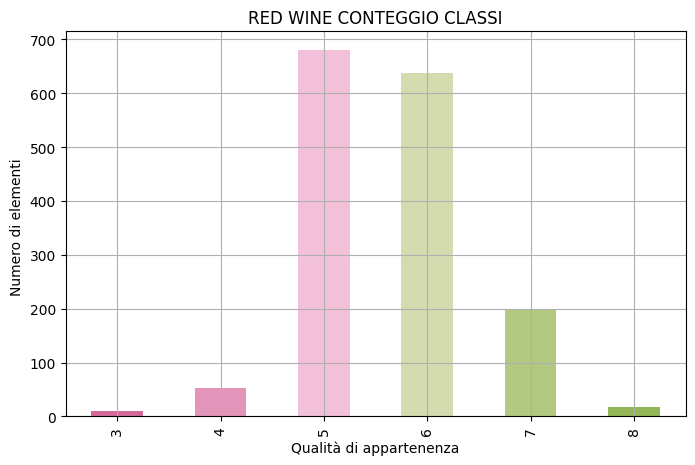

In [3]:
# Si selezionano delle tonalità di rosso e verde colorblind friendly
red_color = '#b51963'
green_color = '#5ba300'

# Tramite light_palette si creano sfumature dei colori selezionati che vengono manualmente
# modificate per aumentarne la luminosità ed evitare colori troppo chiari
red_palette = sns.light_palette(red_color, n_colors=5, reverse=True)
red_palette = [(c[0], c[1]*0.8, c[2]*0.9) for c in red_palette]
green_palette = sns.light_palette(green_color, n_colors=5)
green_palette = [(c[0] * 0.9, c[1]*0.9, c[2] * 0.75) for c in green_palette]
custom_palette = red_palette + green_palette

# Si procede con il selezionare i valori unici della colonna 'quality' e creare un dizionario per i colori
quality_unique_values = np.unique(red_wine['quality'].values)
colors_mapping = dict(zip(np.arange(10)+1, custom_palette))

# Creazione di un dataset contenente i conteggi dei diversi livelli di qualità dei vari campioni e le loro frequenze
N = red_wine.shape[0]
class_cont_freq = pd.concat([red_wine['quality'].value_counts(), red_wine['quality'].value_counts() / N], axis=1)
class_cont_freq.columns = ['counts', 'freq.']
class_cont_freq.index.name = 'class'
class_cont_freq.sort_values('class', inplace=True)
display(class_cont_freq)

# Un plot per mostrare la distribuzione della qualità dei vini, utilizzando la palette personalizzata
plt.figure()
class_cont_freq['counts'].plot.bar(figsize=(8, 5), color=[colors_mapping[q] for q in class_cont_freq.index])
plt.title('RED WINE CONTEGGIO CLASSI')
plt.xlabel("Qualità di appartenenza")
plt.ylabel("Numero di elementi ")
plt.grid()
plt.show()

## PROBLEMA BINARIO
Il problema di multiclassificazione viene diviso in un problema binario accorpando le classi.


In [ ]:
red_wine['quality'] = red_wine['quality'].replace([3, 4, 5], value=0)
red_wine['quality'] = red_wine['quality'].replace([6, 7, 8], value=1)

plt.figure()
red_wine['quality'].value_counts().sort_values().plot.bar(figsize=(8,5), color=[custom_palette[3], custom_palette[7]])
plt.title('CONTEGGIO CLASSI PROBLEMA BINARIO')
plt.xlabel("Qualità di appartenenza")
plt.ylabel("Numero di elementi ")
plt.grid()
